## Analyse a working bitmap file

In this notebook we read a working bmp (bitmap) file and analyse it.  
The header contents are printed in a human readable form and a few entries in the color palette are shown.  
It was use to better understand the bmp file structure, allowing to create a bmp file from a grayscale image, read from the esp32 camera.
Copyright (c) U. Raich, 10. December 2025
This program is part of the course on TinyML at the University of Cape Coast, Ghana
It is released under the MIT license

In [25]:
import struct
from PIL import Image

Let's try to have a look at the bmp image first

In [26]:
bmpFilename = 'capture.bmp'

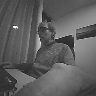

In [27]:
img = Image.open(bmpFilename)
display(img)

In [28]:
bmpFile = open(bmpFilename,'rb')
bmpFileData = bmpFile.read()

In [29]:
print("length of data read: ",len(bmpFileData))

length of data read:  10294


### The bmp header

The bmp header looks like this:

| signification | value | offset | size in bytes | 
| --- | --- | --- | --- |
| magic word | 'BM' | 0 | 2 |  
| header size | 14 | 2 | 4 |  
| reserved | 0 | 6 | 2 |  
| reserved | 0 | 8 | 2 |  
| offset to the pixel data |   | 10 | 4 |  

Integers can only be read with 32 bit alignement. Therefore I first read only the magic word 'BM' and then then rest of the header.


In [30]:
def printByteArray(data):
    for i in range(len(data)-1):
        print("0x{:02x}, ".format(data[i]),end="")
    print("0x{:02x}".format(data[len(data)-1]))

Print the first 14 bytes of the bmp file, which correspond to the bmp header

In [31]:
print("The header data: ")
printByteArray(bmpFileData[0:14])

The header data: 
0x42, 0x4d, 0x36, 0x28, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x36, 0x04, 0x00, 0x00


Let's now analyse the header

In [32]:
HDR_SIZE = 14
magic = bmpFileData[0:2]
hdrRestBytes = bmpFileData[2:HDR_SIZE]
hdrRest = struct.unpack('ihhi',hdrRestBytes)
fileSize = hdrRest[0]
offset = hdrRest[3]
print("Magic word:           ",magic)
print("File size  :           0x{:02x} = {:d}".format(fileSize,fileSize))
print("reserved:             ",hdrRest[1])
print("reserved:             ",hdrRest[2])
print("offset to pixel data:  0x{:02x} = {:d}".format(offset,offset))

Magic word:            b'BM'
File size  :           0x2836 = 10294
reserved:              0
reserved:              0
offset to pixel data:  0x436 = 1078


### The bmp info header

The info header has this format:  
The offset i calculated from the beginning of the bmp file.  
    
| signification | value | offset | size in bytes |
| --- | --- | --- | --- |
| header size |  | 14 | 4|
| bitmap width in pixels |  | 18 | 4 |
| bitmap height in pixels |  | 22 | 4 |
| no of colors | 1 | 26 | 2 |
| number of bits per pixel |  | 28 | 2 |
| compression method |  | 30 | 4 |
| image size |  |  34 | 4 |
| horizontal resolution pixels/m |  | 38 | 4 |
| vertical resolution pixels/m |  | 42 | 4 |
| number of colors in palette |  | 46 | 4 |
| number of important colors |  | 50 | 4 |

In [33]:
infoData = bmpFileData[14:54]
infoHdr = struct.unpack('3i2h6i',infoData)
print("Info header size: ",infoHdr[0])
print("bitmap width: ",infoHdr[1])
print("bitmap height: ",infoHdr[2])
print("number of color planes: ",infoHdr[3])
print("number of bits per pixel: ",infoHdr[4])
print("compression method: ",infoHdr[5])
print("image size: ",infoHdr[6])
print("horizontal resolution",infoHdr[7])
print("vertical resolution",infoHdr[8])
print("no of colors: ",infoHdr[9])
print("no of important colors: ",infoHdr[10])

Info header size:  40
bitmap width:  96
bitmap height:  96
number of color planes:  1
number of bits per pixel:  8
compression method:  0
image size:  18432
horizontal resolution 0
vertical resolution 0
no of colors:  256
no of important colors:  0


print the first few entries of the palette

In [34]:
palettePosition = HDR_SIZE + len(infoData)
print("Position of palette: ",palettePosition)

Position of palette:  54


The size of the palette is 256 (grayscale color entries) * 4 bytes  
Each entry has the form:
* AA: transparency
* RR: red component
* GG: green component
* BB: blue component

In [35]:
palette = bmpFileData[palettePosition:palettePosition+256*4]

In [36]:
print("The first ten entries in the palette:")
for i in range(10):
    print("{:d}: 0x{:02x}".format(i,palette[4*i+3]),end="")
    print("{:02x}".format(palette[4*i+2]),end="")
    print("{:02x}".format(palette[4*i+1]),end="")
    print("{:02x}".format(palette[4*i]))
print("Length of the palette in bytes: ",len(palette))

The first ten entries in the palette:
0: 0xff000000
1: 0xff010101
2: 0xff020202
3: 0xff030303
4: 0xff040404
5: 0xff050505
6: 0xff060606
7: 0xff070707
8: 0xff080808
9: 0xff090909
Length of the palette in bytes:  1024


The rest of the file contains the pixel data as 8 bit grayscale values